In [1]:
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib.colors as col
from scipy import ndimage as nd
from matplotlib.collections import LineCollection

compression = 0.5
azim = 180+45.
elev = 30.

In [2]:
def gaussian(x,y,a,b,mx,my,vx,vy):
    return a*np.exp(-.5*((x-mx)**2./vx + (y-my)**2./vy)) + b

In [3]:
def degrid(a):
    #this function gets rid of the grids which are default in matplotlib 3D plots
    a.grid(False)
    # a.xaxis.pane.set_edgecolor(None)
    # a.yaxis.pane.set_edgecolor(None)
    
    a.xaxis.pane.fill = False
    a.yaxis.pane.fill = False
    a.zaxis.pane.fill = False
    a.xaxis.pane.set_visible(False)
    a.yaxis.pane.set_visible(False)
    a.zaxis.pane.set_visible(False)
    
    # a.set_axis_off()
    # a.set_xticks([0.,1./3.,1.])
    
    a.xaxis.line.set_visible(False)
    a.yaxis.line.set_visible(False)
    a.zaxis.line.set_visible(False)
    a.set_xticks((),())
    a.set_yticks((),())
    a.set_zticks((),())

In [4]:
def make_noise(gx,seed=None):
    if not seed is None:
        np.random.seed(seed)
    noise = (np.random.rand(*gx.shape)-.5)*1.
    noise = nd.gaussian_filter(nd.maximum_filter(noise,25) - nd.minimum_filter(noise,25),4.)
    noise -= noise.min()
    noise /= noise.max()
    noise = np.sqrt(noise)
    noise -= .5
    noise *= z.mean()*2.
    return noise

In [5]:
def make_landscape():
    global a1,a2,a3,a4,a5,a6,a7,a8,a9,m1,m2,m3,m4,m5,m6,m7,m8,m9
    gx,gy = np.meshgrid(np.linspace(-5,5,1024),np.linspace(-5,5,1024))
    z = -1.*((gaussian(gx,gy,a1,0,m1[0],m1[1],.1,.1) + gaussian(gx,gy,a2,0,m2[0],m2[1],.2,.2)\
            + gaussian(gx,gy,a3,0,m3[0],m3[1],.1,.1) + gaussian(gx,gy,a4,0,m4[0],m4[1],.1,.1)\
            + gaussian(gx,gy,a5,0,m5[0],m5[1],.1,.1) + gaussian(gx,gy,a6,0,m6[0],m6[1],.2,.2)\
            + gaussian(gx,gy,a7,0,m7[0],m7[1],.1,.1) + gaussian(gx,gy,a8,0,m8[0],m8[1],.2,.2)\
            + gaussian(gx,gy,a9,0,m9[0],m9[1],.1,.1)))**compression
    return gx,gy,z



In [6]:
temp = plt.cm.get_cmap('Greys_r', 512)
newcmp = col.ListedColormap(temp(np.linspace(0.05, 0.85, 512)))


In [7]:
def make_plot(gx,gy,z,nlevels=256,fn='test',path=None,pathstart=800):
    ## You must manually composite these figures together in order to get the lines on top of the surfaces.... thanks MPL...

    global azim,elev

    nn = 1000

    delta = z.max()-z.min()
    zlow = z.min()-delta*.2
    zhigh = z.max()+delta*.1

    ncut = gx.shape[1]//3

    cmap = newcmp
    from matplotlib.colors import LightSource
    ls = LightSource(135, 60)
    rgb1 = ls.shade(z[:,ncut:], cmap=cmap, vert_exag=0.2, blend_mode='soft')
    rgb2 = ls.shade(z, cmap=cmap, vert_exag=0.1, blend_mode='soft')

    
    fig = plt.figure(figsize=(6,4.5),dpi=300)
    ax = fig.add_subplot(111, projection='3d')

    ax.set_xlim(-5,5)
    ax.set_zlim(zlow,zhigh)
    ax.view_init(elev=elev, azim=azim)
    degrid(ax)
    
    ax.plot_surface(gx,gy,z,facecolors=rgb2,rcount=nlevels,ccount=nlevels,linewidth=0, antialiased=False, shade=False,zorder=0)

    fig.tight_layout()
    plt.show()
    #fig.savefig('%s_part1.png'%(fn),transparent=True)
 

In [ ]:
def mc_walk(gx,gy,z,seed=105,nsteps=1000,beta = 4.,halfcut=False):
    #this function makes a Markov chain walker for the specific landscape
    np.random.seed(seed)

    xx = gx[0]
    yy = gy[:,0]
    from scipy.interpolate import RegularGridInterpolator
    interpolated = RegularGridInterpolator((xx,yy),z.T)

    d = np.zeros((nsteps,2))
    ll = np.zeros(nsteps)
    d[0] = m2
    ll[0] = interpolated(d[0])

    f = 0.
    for i in range(nsteps-1):

        ## Current position
        dold = d[i]
        try:
            zold = interpolated(dold)
        except:
            zold = 0.

        ## new move with PBC
        dnew = dold + np.random.normal(loc=0,scale=.1,size=2)
        
        if halfcut:
            if dnew[0] <=0:
                dnew[0] *= -1.

        try:
            znew = interpolated(dnew)
        except:
            znew = 0.

        ## MH acceptance calc
        a = np.min((1.,np.exp(-beta*znew)/np.exp(-beta*zold)))
        p = np.random.uniform()
        # print(i,a,p,a<=p,dnew)
        if p <= a and dnew[0] > xx.min() and dnew[1] > yy.min() and dnew[0] < xx.max() and dnew[1] < yy.max():
            d[i+1] = dnew.copy()
            ll[i+1] = znew
            f+= 1.
        else:
            d[i+1] = dold.copy()
            ll[i+1] = zold
    print("acceptance: ",f/nsteps)

    # start = 800
    # f,a = plt.subplots(2)
    # a[0].contourf(gy,gx,z,50)
    # a[0].plot(d[start:,1],d[start:,0],'k')
    # a[1].plot(ll,'k')
    # plt.show()

    return d,ll

In [ ]:
# Topics: line, color, LineCollection, cmap, colorline, codex
'''
Defines a function colorline that draws a (multi-)colored 2D line with coordinates x and y.
The color is taken from optional data in z, and creates a LineCollection.

z can be:
- empty, in which case a default coloring will be used based on the position along the input arrays
- a single number, for a uniform color [this can also be accomplished with the usual plt.plot]
- an array of the length of at least the same length as x, to color according to this data
- an array of a smaller length, in which case the colors are repeated along the curve

The function colorline returns the LineCollection created, which can be modified afterwards.

See also: plt.streamplot
'''


# Data manipulation:

def make_segments(x, y):
    '''
    Create list of line segments from x and y coordinates, in the correct format for LineCollection:
    an array of the form   numlines x (points per line) x 2 (x and y) array
    '''

    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    
    return segments


# Interface to LineCollection:

def colorline(x, y, z=None, cmap=plt.get_cmap('copper'), norm=plt.Normalize(0.0, 1.0), linewidth=3, alpha=1.0):
    '''
    Plot a colored line with coordinates x and y
    Optionally specify colors in the array z
    Optionally specify a colormap, a norm function and a line width
    '''
    
    # Default colors equally spaced on [0,1]:
    if z is None:
        z = np.linspace(0.0, 1.0, len(x))
           
    # Special case if a single number:
    if not hasattr(z, "__iter__"):  # to check for numerical input -- this is a hack
        z = np.array([z])
        
    z = np.asarray(z)
    
    segments = make_segments(x, y)
    lc = LineCollection(segments, array=z, cmap=cmap, norm=norm, linewidth=linewidth, alpha=alpha)
    
    ax = plt.gca()
    ax.add_collection(lc)
    
    return lc
        
    
def clear_frame(ax=None): 
    # Taken from a post by Tony S Yu
    if ax is None: 
        ax = plt.gca() 
    ax.xaxis.set_visible(False) 
    ax.yaxis.set_visible(False) 
    for spine in ax.spines.itervalues(): 
        spine.set_visible(False) 

In [ ]:
temp = plt.cm.get_cmap('Greens_r', 512)
newcmp_2 = col.ListedColormap(temp(np.linspace(0.25, 1., 512)))

In [ ]:
a1 = 11
a2 = 15
m1 = [-1.5,-1.5]
m2 = [1.5,1.5]
gx_2,gy_2 = np.meshgrid(np.linspace(-3.,3.,1024),np.linspace(-3.,3.,1024))
z_2 = -1.*(gaussian(gx_2,gy_2,a1,0,m1[0],m1[1],0.8,0.8) + gaussian(gx_2,gy_2,a2,0,m2[0],m2[1],0.8,0.8))
z_2 += (gx_2**2 + gy_2**2)*0.35
#vacant s1 = s2 = 0.4
#fMet s1 = 0.8, s2 = 0.8
#Phe s1 = 0.8, s2 = 0.8
seed = 105
factor = 0.5
noise = make_noise(gx_2,seed=seed)
z_2 -= noise*factor
z_2 -= z_2.min()-1

nlevels = 100
delta = z_2.max()-z_2.min()
zlow = z_2.min()-delta*.2
zhigh = z_2.max()+delta*.1


print(z_2.min())
print(z_2.max())



In [ ]:
seed = np.random.randint(10000)
d_1,ll_1 = mc_walk(gx_2,gy_2,z_2,seed=12,nsteps=725,beta=0.18,halfcut=False)
print(d_1[-1])
print(seed)
#2570,4128,4980,2808,8765,12,9139,9491,6488,650

In [ ]:
fig, ax = plt.subplots(figsize=(5,5))
ax.axis('off')
plt.contourf(gx_2,gy_2,z_2,levels=100,cmap="Purples_r")
plt.clim(vmin = 0.5, vmax =23)
plt.savefig('test.png', format='png', bbox_inches = 'tight')
fig, ax = plt.subplots(figsize=(5,5))
ax.axis('off')
plt.contour(gx_2,gy_2,z_2,levels=14, colors = '#1100775a')
colorline(d_1[:,0],d_1[:,1],cmap = newcmp_2, linewidth = 2,alpha = 1.)
plt.savefig('test2.pdf', format='pdf', bbox_inches = 'tight')
plt.show()
#print(d)

In [ ]:
a1 = 11
a2 = 15
a3 = 7
m1 = [-1.5,-1.5]
m2 = [1.5,1.5]
m3 = [-0.05, -0.05]
gx_2,gy_2 = np.meshgrid(np.linspace(-3.,3.,1024),np.linspace(-3.,3.,1024))
z_4 = -1.*((gaussian(gx_2,gy_2,a1,0,m1[0],m1[1],0.8,0.8) + gaussian(gx_2,gy_2,a2,0,m2[0],m2[1],0.8,0.8) +  gaussian(gx_2,gy_2,a3,0,m3[0],m3[1],0.4,0.4)))
z_4 += (gx_2**2 + gy_2**2)*0.3

#vacant s1 = s2 = 0.4
#fMet s1 = 0.8, s2 = 0.8
#Phe s1 = 0.8, s2 = 0.8
seed = 100
factor = 0.5
noise = make_noise(gx_2,seed=seed)
z_4 -= noise*factor
print(z_4.min())
z_4 -= z_4.min()-1

nlevels = 100
delta = z_4.max()-z_4.min()
zlow = z_4.min()-delta*.2
zhigh = z_4.max()+delta*.1

print(z_4.min())
print(z_4.max())


In [ ]:
seed =  np.random.randint(10000)
#14, 20220
d_3,ll_3 = mc_walk(gx_2,gy_2,z_4,seed=2315,nsteps=290,beta=0.18,halfcut=False)
print(seed)
print(d_3[-1])
#2570,4128,4980,2808,8765,12,9139,9491,6488,650,8520,9164,7630(260)

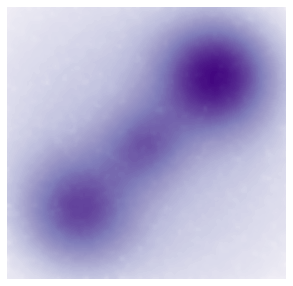

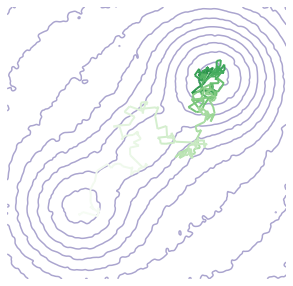

In [31]:
fig, ax = plt.subplots(figsize=(5,5))
ax.axis('off')
plt.contourf(gx_2,gy_2,z_4,levels=100,cmap="Purples_r")
plt.clim(vmin = 0.5, vmax = 23)
plt.savefig('test_3.png', format='png', bbox_inches = 'tight')
#plt.plot(d_3[:,0], d_3[:,1], 'white')
fig, ax = plt.subplots(figsize=(5,5))
ax.axis('off')
plt.contour(gx_2,gy_2,z_4,levels=12, colors = '#1100775a')
colorline(d_3[:,0],d_3[:,1],cmap = newcmp_2, linewidth = 2,alpha = 1.)
plt.savefig('test2_3.pdf', format='pdf', bbox_inches = 'tight')
plt.show()
#print(d)

In [27]:
def sigmoid(x):
    return np.exp(1.5*(x-2.))/(np.exp(1.5*(x-2.)) + 1)

In [28]:
a1 = 11
a2 = 15
m1 = [-1.6,-1.6]
m2 = [1.6,1.6]
gx_2,gy_2 = np.meshgrid(np.linspace(-3.,3.,1024),np.linspace(-3.,3.,1024))
z_3 = -1.*(gaussian(gx_2,gy_2,a1,0,m1[0],m1[1],0.5,0.5) + gaussian(gx_2,gy_2,a2,0,m2[0],m2[1],0.6,0.6))
r = np.sqrt(gx_2**2 + gy_2**2)
z_3 += (sigmoid(r))*18/1.2
#vacant s1 = s2 = 0.4
#fMet s1 = 0.8, s2 = 0.8
#Phe s1 = 0.8, s2 = 0.8
seed = 110
factor = 0.5
noise = make_noise(gx_2,seed=seed)
z_3 -= noise*factor
z_3 -= z_3.min()-1

nlevels = 100
delta = z_3.max()-z_2.min()
zlow = z_3.min()-delta*.2
zhigh = z_3.max()+delta*.1


print(z_3.min())
print(z_3.max())



1.0
22.786696389734907


In [44]:
seed =  np.random.randint(10000)
#14, 20220
d_2,ll_2 = mc_walk(gx_2,gy_2,z_3,seed=8121,nsteps=253,beta=0.18,halfcut=False)
print(seed)
print(d_2[-1])
#2570,4128,4980,2808,8765,12,9139,9491,6488,650,8520,9164,7630(260),5469,8121,8619

acceptance:  0.9525691699604744
1513
[-1.63045547 -1.30734816]


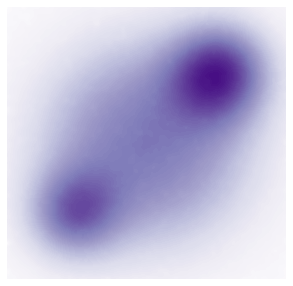

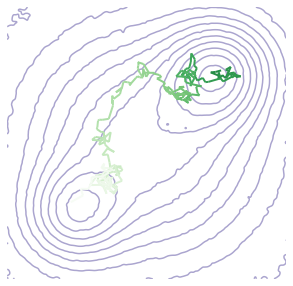

In [47]:
fig, ax = plt.subplots(figsize=(5,5))
ax.axis('off')
plt.contourf(gx_2,gy_2,z_3,levels=100,cmap='Purples_r',alpha = 1)
plt.clim(vmin = 0., vmax = 23)
#plt.colorbar(orientation = 'horizontal')
plt.savefig('test_2.pdf', format='pdf', bbox_inches = 'tight')
fig, ax = plt.subplots(figsize=(5,5))
ax.axis('off')
plt.contour(gx_2,gy_2,z_3,levels=13, colors = '#1100775a')
colorline(d_2[:,0], d_2[:,1], cmap = newcmp_2, linewidth = 2,alpha = 1.)
plt.savefig('test2_2.pdf', format='pdf', bbox_inches = 'tight')
plt.show()
#print(d)